In [ ]:
# Requirements
!pip install numpy matplotlib scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.io
import matplotlib.patches as patches
import scipy.misc
import skimage.transform

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams.update({'font.size': 18})

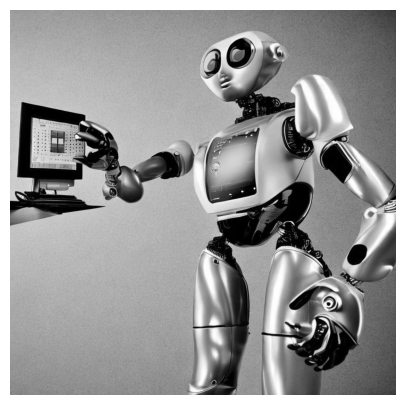

In [ ]:
# Work with images

A = imread(os.path.join('/content/drive/My Drive/MLR_DATA','robot-remote.jpeg'))
X = np.mean(A, -1); # Convert RGB to grayscale

img = plt.imshow(X)
img.set_cmap('gray')
plt.axis('off')
plt.show()

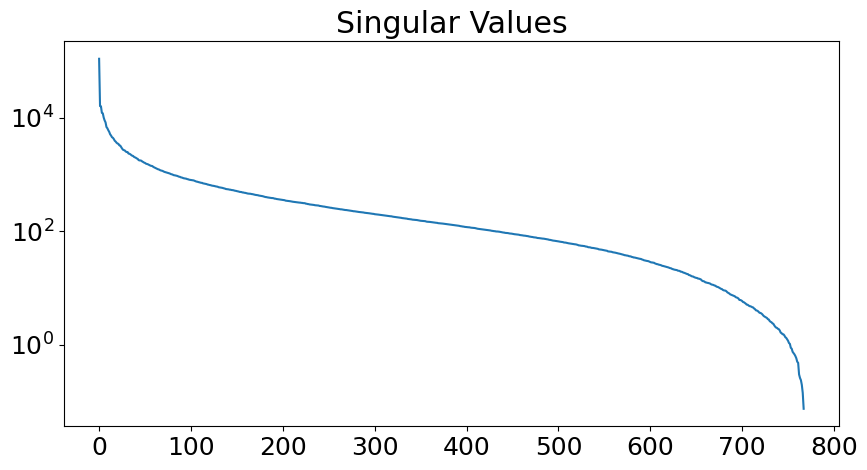

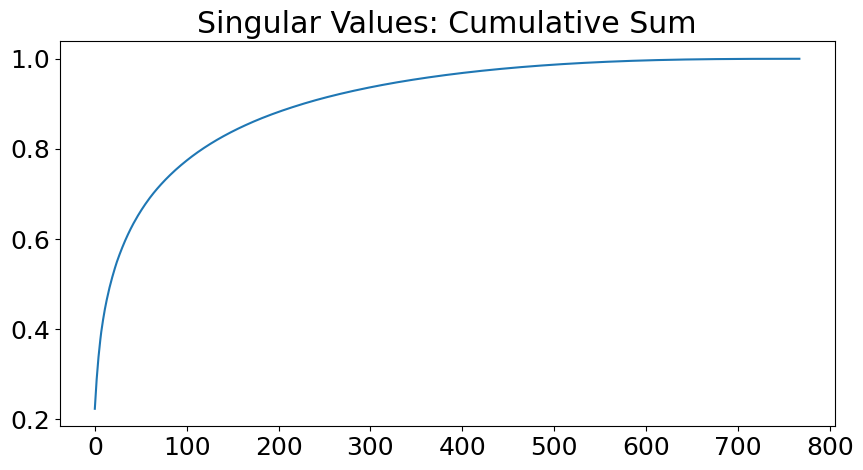

In [ ]:
# SVD and singular values analysis

U, S, VT = np.linalg.svd(X,full_matrices=False)
S = np.diag(S)

plt.figure(1)
plt.semilogy(np.diag(S))
plt.title('Singular Values')
plt.show()

plt.figure(2)
plt.plot(np.cumsum(np.diag(S))/np.sum(np.diag(S)))
plt.title('Singular Values: Cumulative Sum')
plt.show()

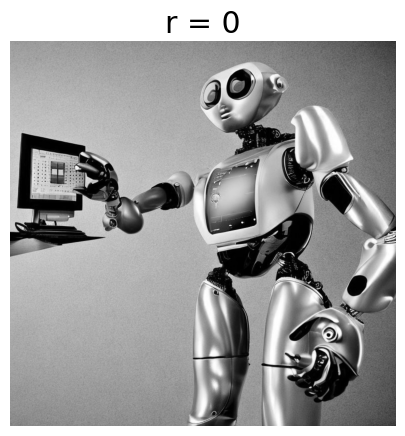

In [ ]:
# Task 1
# Complete the code to recover initial image from truncated SVD
# Define truncation from two methods: optimal truncation cut-below threshold and based on importance metrics

# modify code here
r = 0
Xapprox = U[:,:] @ S[:,:] @ VT[:,:]

# output image
img = plt.imshow(Xapprox)
img.set_cmap('gray')
plt.axis('off')
plt.title('r = ' + str(r))
plt.show()


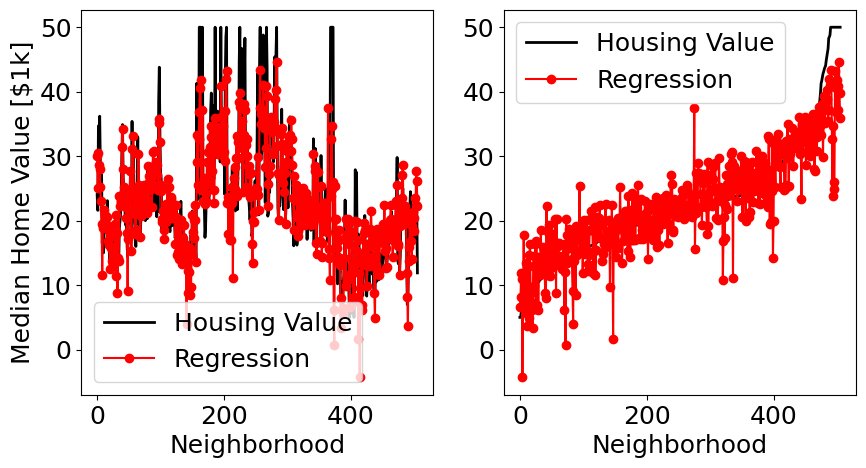

In [ ]:
# Load dataset
H = np.loadtxt(os.path.join('/content/drive/My Drive/MLR_DATA','housing.data'))
b = H[:,-1] # housing values in $1000s
A = H[:,:-1] # other factors

# Pad with ones for nonzero offset
A = np.pad(A,[(0,0),(0,1)],mode='constant',constant_values=1)

# Solve Ax=b using SVD
U, S, VT = np.linalg.svd(A,full_matrices=0)
x = VT.T @ np.linalg.inv(np.diag(S)) @ U.T @ b

fig = plt.figure()
ax1 = fig.add_subplot(121)

plt.plot(b, c='k', linewidth=2, label='Housing Value') # True relationship
plt.plot(A@x, '-o', c='r', linewidth=1.5, markersize=6, label='Regression')


plt.xlabel('Neighborhood')
plt.ylabel('Median Home Value [$1k]')
plt.legend()

ax2 = fig.add_subplot(122)
sort_ind = np.argsort(H[:,-1])
b = b[sort_ind] # sorted values
plt.plot(b, c='k', linewidth=2, label='Housing Value') # True relationship
plt.plot(A[sort_ind,:]@x, '-o', c='r', linewidth=1.5, markersize=6, label='Regression')


plt.xlabel('Neighborhood')
plt.legend()

plt.show()

In [ ]:
# Task 2
# Split housing prices dataset to training and test parts
# Estimate regresson from the training subset and validate on the testing one
# Plot validation results

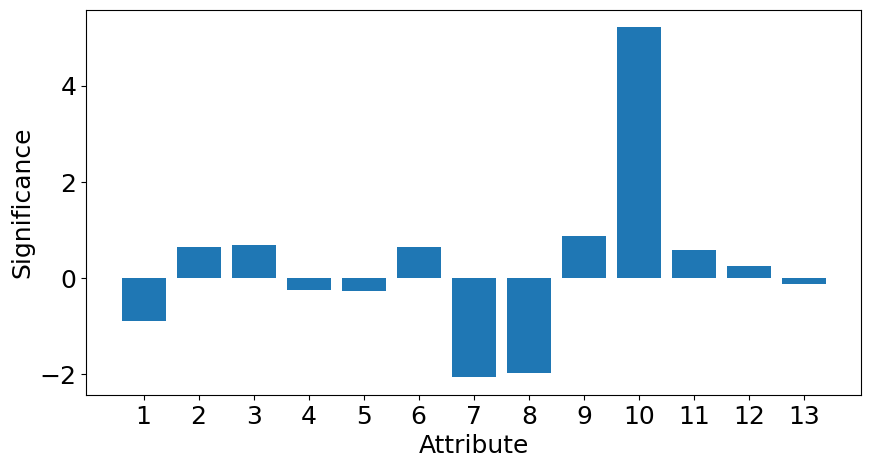

In [ ]:
# Discover significance (correlation) of different factors

# Task 3 - FIX ERROR - perform standartization of data

A2 = A # apply changes here

for j in range(A.shape[1]-1):
    A2std = np.std(A2[:,j])
    A2[:,j] = A2[:,j]/A2std

A2[:,-1] = np.ones(A.shape[0])

U, S, VT = np.linalg.svd(A2,full_matrices=0)
x = VT.T @ np.linalg.inv(np.diag(S)) @ U.T @ b
x_tick = range(len(x)-1)+np.ones(len(x)-1)
plt.bar(x_tick,x[:-1])
plt.xlabel('Attribute')
plt.ylabel('Significance')
plt.xticks(x_tick)
plt.show()

In [ ]:
# Robustness check for faces

plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams.update({'font.size': 18})

mat_contents = scipy.io.loadmat(os.path.join('/content/drive/My Drive/MLR_DATA','allFaces.mat'))
faces = mat_contents['faces']
m = int(mat_contents['m'])
n = int(mat_contents['n'])
nfaces = np.ndarray.flatten(mat_contents['nfaces'])

allPersons = np.zeros((n*6,m*6))
count = 0

for j in range(6):
    for k in range(6):
        allPersons[j*n : (j+1)*n, k*m : (k+1)*m] = np.reshape(faces[:,np.sum(nfaces[:count])],(m,n)).T
        count += 1

img = plt.imshow(allPersons)
img.set_cmap('gray')
plt.axis('off')
plt.show()

In [ ]:
# We use the first 36 people for training data
trainingFaces = faces[:,:np.sum(nfaces[:36])]
avgFace = np.mean(trainingFaces,axis=1) # size n*m by 1

# Compute eigenfaces on mean-subtracted training data
X = trainingFaces - np.tile(avgFace,(trainingFaces.shape[1],1)).T
U, S, VT = np.linalg.svd(X,full_matrices=0)

fig1 = plt.figure()
ax1 = fig1.add_subplot(121)
img_avg = ax1.imshow(np.reshape(avgFace,(m,n)).T)
img_avg.set_cmap('gray')
plt.axis('off')

ax2 = fig1.add_subplot(122)
img_u1 = ax2.imshow(np.reshape(U[:,0],(m,n)).T)
img_u1.set_cmap('gray')
plt.axis('off')

plt.show()

In [ ]:
## Now show eigenface reconstruction of image that was omitted from test set

testFace = faces[:,np.sum(nfaces[:37])] # First face of person 37
plt.imshow(np.reshape(testFace,(m,n)).T)
plt.set_cmap('gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

# Task 4
# Reconstruct test face from obtained estimates of eigenfaces

r_list = [1] #
testFaceMS = testFace # fix it


for r in r_list:
    reconFace = avgFace # fix it
    img = plt.imshow(np.reshape(reconFace,(m,n)).T)
    img.set_cmap('gray')
    plt.title('r = ' + str(r))
    plt.axis('off')
    plt.show()

In [ ]:
# LASSO algorithm

from sklearn import linear_model
from sklearn import model_selection

plt.rcParams['figure.figsize'] = [7, 7]
plt.rcParams.update({'font.size': 18})

A = np.random.randn(100,10) # Matrix of possible predictors
x = np.array([0, 0, 1, 0, 0, 0, -1, 0, 0, 0]) #Two nonzero predictors
b = A @ x + 2*np.random.randn(100)

xL2 = np.linalg.pinv(A) @ b

reg = linear_model.LassoCV(cv=10).fit(A, b)

lasso = linear_model.Lasso(random_state=0, max_iter=10000)
alphas = np.logspace(-4, -0.5, 30)

tuned_parameters = [{'alpha': alphas}]

clf = model_selection.GridSearchCV(lasso, tuned_parameters, cv=10, refit=False)
clf.fit(A, b)

scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
plt.semilogx(alphas, scores,'r-')

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(10)

plt.semilogx(alphas, scores + std_error, 'k--')
plt.semilogx(alphas, scores - std_error, 'k--')
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.1,color='k')

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[-1], alphas[0]])

plt.show()

In [ ]:
XL1 = linear_model.Lasso(alpha=clf.best_params_['alpha'])
XL1.fit(A,b)
xL1 = XL1.coef_
xL1DeBiased = np.linalg.pinv(A[:,np.abs(xL1)>0]) @ b

In [ ]:
# Robust PCA

plt.rcParams['figure.figsize'] = [7, 7]
plt.rcParams.update({'font.size': 18})

mat = scipy.io.loadmat(os.path.join('/content/drive/My Drive/MLR_DATA','allFaces.mat'))
faces = mat['faces']
nfaces = mat['nfaces'].reshape(-1)

## Function Definitions

def shrink(X,tau):
    Y = np.abs(X)-tau
    return np.sign(X) * np.maximum(Y,np.zeros_like(Y))
def SVT(X,tau):
    U,S,VT = np.linalg.svd(X,full_matrices=0)
    out = U @ np.diag(shrink(S,tau)) @ VT
    return out
# Task 5
# Implement robust PCA algorithms
def RPCA(X):


    S = np.zeros_like(X)
    Y = np.zeros_like(X)
    L = np.zeros_like(X)

    return L,S

In [ ]:
X = faces[:,:nfaces[0]]
L,S = RPCA(X)

inds = (1,30)

for k in inds:
    fig,axs = plt.subplots(2,2)
    axs = axs.reshape(-1)
    axs[0].imshow(np.reshape(X[:,k-1],(168,192)).T,cmap='gray')
    axs[0].set_title('X')
    axs[1].imshow(np.reshape(L[:,k-1],(168,192)).T,cmap='gray')
    axs[1].set_title('L')
    axs[2].imshow(np.reshape(S[:,k-1],(168,192)).T,cmap='gray')
    axs[2].set_title('S')
    for ax in axs:
        ax.axis('off')

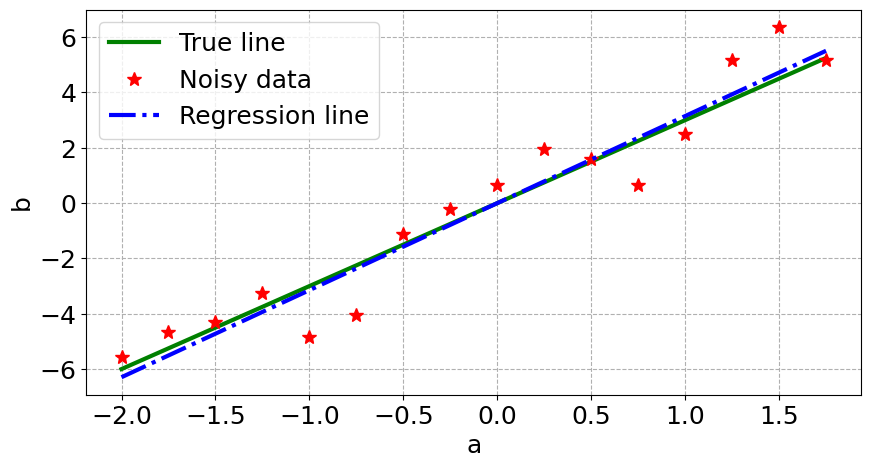

In [ ]:
# Work with noisy data

x = 3 # True slope
a = np.arange(-2,2,0.25)
a = a.reshape(-1, 1)
b = x*a + np.random.randn(*a.shape) # Add noise

plt.plot(a, x*a, c='g', linewidth=3, label='True line') # True relationship
plt.plot(a, b, '*', c='r', markersize = 10, label='Noisy data') # Noisy measurements

U, S, VT = np.linalg.svd(a,full_matrices=False)
xtilde = VT.T @ np.linalg.inv(np.diag(S)) @ U.T @ b # Least-square fit

plt.plot(a,xtilde * a,'-.', c='b', linewidth=3, label='Regression line')

plt.xlabel('a')
plt.ylabel('b')

plt.grid(linestyle='--')
plt.legend()
plt.show()

In [ ]:
# Optimal trunctaion for noisy data

plt.rcParams['figure.figsize'] = [8, 8]

t = np.arange(-3,3,0.01)

Utrue = np.array([np.cos(17*t) * np.exp(-t**2), np.sin(11*t)]).T
Strue = np.array([[2, 0],[0, 0.5]])
Vtrue = np.array([np.sin(5*t) * np.exp(-t**2), np.cos(13*t)]).T

X = Utrue @ Strue @ Vtrue.T

plt.imshow(X)
plt.set_cmap('gray')
plt.axis('off')
plt.show()

In [ ]:
# Adding noise to data
sigma = 1
Xnoisy = X + sigma*np.random.randn(*X.shape)
plt.imshow(Xnoisy)
plt.set_cmap('gray')
plt.axis('off')
plt.show()

print(Xnoisy.shape)

In [ ]:
# Ad-hoc truncation from cumulative sum

cdS = np.cumsum(S) / np.sum(S) # Cumulative energy
r90 = np.min(np.where(cdS > 0.9)) # Find r to capture 90% energy

print(r90)

X90 = U[:,:(r90+1)] @ np.diag(S[:(r90+1)]) @ VT[:(r90+1),:]
plt.imshow(X90)
plt.set_cmap('gray')
plt.axis('off')
plt.show()

In [ ]:
# Task 6
# Implement optimal truncation algorithm

U, S, VT = np.linalg.svd(Xnoisy,full_matrices=0)
N = Xnoisy.shape[0]
cutoff = 1 # fix it - calculate Threshold
r = 1 # fix it - calculate optimal trunctaion ranking

print(r)

Xclean = U[:,:(r+1)] @ np.diag(S[:(r+1)]) @ VT[:(r+1),:]
plt.imshow(Xclean)
plt.set_cmap('gray')
plt.axis('off')
plt.show()

In [ ]:
## Compare optimal truncation with ad-hoc

fig1,ax1 = plt.subplots(1)

ax1.semilogy(S,'-o', color='k', linewidth=2)
ax1.semilogy(np.diag(S[:(r+1)]),'o', color='r', linewidth=2)
ax1.plot(np.array([-20, N+20]),np.array([cutoff, cutoff]),'--', color='r', linewidth=2)
rect = patches.Rectangle((-5,20),100,200,linewidth=2,linestyle='--',facecolor='none',edgecolor='k')
ax1.add_patch(rect)
plt.xlim((-10,610))
plt.ylim((0.003,300))
ax1.grid()
plt.show()

fig2,ax2 = plt.subplots(1)

ax2.semilogy(S,'-o', color='k', linewidth=2)
ax2.semilogy(np.diag(S[:(r+1)]),'o', color='r', linewidth=2)
ax2.plot(np.array([-20, N+20]),np.array([cutoff, cutoff]),'--', color='r', linewidth=2)
plt.xlim((-5,100))
plt.ylim((20,200))
ax2.grid()
plt.show()

fig3,ax3 = plt.subplots(1)
ax3.plot(cdS,'-o',color='k',linewidth=2)
ax3.plot(cdS[:(r90+1)],'o',color='b',linewidth=2)
ax3.plot(cdS[:(r+1)],'o',color='r',linewidth=2)
plt.xticks(np.array([0, 300, r90, 600]))
plt.yticks(np.array([0, 0.5, 0.9, 1]))
plt.xlim((-10,610))
ax3.plot(np.array([r90, r90, -10]),np.array([0, 0.9, 0.9]),'--',color='b',linewidth=2)

ax3.grid()
plt.show()